# Engine Design Calculations

In [29]:
from matplotlib import pyplot as plt
from lib import cea
import numpy as np
from scipy import constants
import thermo
import fluids

## Initial parameters

In [30]:
equilibrium = True

fuel_chems = ('JP-5',) #allows specifying a mixture of chemicals in the fuel
fuel_percs = (100,) #see the CEA docs for which formula strings will work
rho_fuel_kgpm3 = 810
T_initial_fuel_K = 298

ox_chem = 'O2'
T_initial_ox_K = 298
P_initial_ox_bar = 200

r_of_mass = 1.85
L_char_m = 1.3 #combustion characteristic length

F_thrust_N = 3000 # thas right.
dt_burn_s = 30 #max. burn time (for test stand run duration)
P_chamber_bar = 30
P_ambient_bar = 1.013

T_std_K = 289 #60degF is standard conditions for finding SCFM flow rate
P_std_bar = 1.013 #1atm is ...
P_fuel_tank_bar = 40

## Combustion analysis

In [31]:
#setup input data
cea_inp = cea.CEAInputData()
cea_inp.equilibrium = equilibrium
cea_inp.fuel_chems = fuel_chems
cea_inp.fuel_chem_mass_percs = fuel_percs
cea_inp.ox_chem = ox_chem
cea_inp.fuel_initial_temp = T_initial_fuel_K
cea_inp.ox_initial_temp = T_initial_ox_K
cea_inp.pcham = P_chamber_bar
cea_inp.pamb = P_ambient_bar

#run CEA
cea.create_inp_file(cea_inp)
cea.run_executable()
out = cea.parse_out_file()

#setup output data
T_chamber_K = out.chamber_temp
v_exhaust_mps = out.exhaust_velocity
c_star_mps = out.cstar
gamma_exhaust = out.exhaust_gamma
M_exhaust_kgpkmol = out.exhaust_molar_mass

print(f'Exhaust speed: {v_exhaust_mps:.1f}m/s (specific impulse of {v_exhaust_mps/9.81:.1f}s)')
print(f'Exhaust properties: gamma={gamma_exhaust}, M={M_exhaust_kgpkmol}kg/kmol')
print(f'Chamber temperature: {T_chamber_K:.1f}K')

Exhaust speed: 2087.2m/s (specific impulse of 212.8s)
Exhaust properties: gamma=1.133, M=17.073kg/kmol
Chamber temperature: 1601.1K


## Nozzle & chamber

In [32]:
#input parameters
r_A_converging = 8 #converging section area ratio (chamber area / throat area)
theta_diverging_deg = 20
theta_converging_deg = 45

In [33]:
# def c_star(exhaust_gamma, exhaust_molar_mass, chamber_temp):
#     exhaust_R = R / exhaust_molar_mass
#     c_star = np.sqrt(exhaust_gamma * exhaust_R * chamber_temp) / exhaust_gamma * \
#         ((exhaust_gamma + 1) / 2) ** ((exhaust_gamma + 1) / (2 * (exhaust_gamma - 1)))
#     return c_star


def exhaust_velocity(exhaust_gamma, exhaust_molar_mass, chamber_temp, chamber_pressure, ambient_pressure):
    '''returns exhaust velocity, assuming isentropic expansion of gases to ambient pressure at exit'''
    k = exhaust_gamma
    R = constants.R * 1e3 / exhaust_molar_mass
    PR = ambient_pressure / chamber_pressure
    exhaust_velocity = np.sqrt((2*k)/(k-1) * R * chamber_temp *
                                 (1 - PR ** ((k - 1) / k)))
    return exhaust_velocity


def expansion_ratio(exhaust_gamma, chamber_pressure, ambient_pressure):
    '''returns optimum expansion ratio, assuming isentropic expansion of gases to ambient pressure at exit'''
    k = exhaust_gamma
    PR = ambient_pressure / chamber_pressure
    expansion_ratio = 1 / ((((k+1)/2)**(1/(k-1))) * (PR**(1/k))
                           * np.sqrt((k + 1) / (k-1) * (1 - PR ** ((k - 1) / k))))
    return expansion_ratio


def throat_area(exhaust_gamma, exhaust_molar_mass, mass_flow, chamber_temp, chamber_pressure):
    '''returns throat area required for choked flow to occur'''
    k = exhaust_gamma
    R = constants.R * 1e3 / exhaust_molar_mass
    throat_area = mass_flow / \
        (chamber_pressure*constants.bar * k / np.sqrt(k*R*chamber_temp)
         * (2 / (k + 1)) ** ((k + 1) / 2 / (k - 1)))
    return throat_area


def cone_length(r1, r2, theta):
    '''length of cone with top and bottom radii r1, r2 and half-angle theta'''
    return abs(r2-r1) / np.tan(np.radians(theta))


def chamber_length(Vch, Lcon, Ach, At):
    '''length of cylindrical part of chamber, given total chamber volume (cylinder + conical converging section), 
    length of converging section, areas of chamber and throat'''
    Vcon = Ach * Lcon * (1 + np.sqrt(At / Ach) + At / Ach)
    return (Vch - Vcon) / Ach


In [34]:
# check CEA values using simpler calc. of performance
R_exhaust_JpkmolK = constants.R * 1e3 / M_exhaust_kgpkmol
v_exhaust_isentropic_mps = exhaust_velocity(
    gamma_exhaust, M_exhaust_kgpkmol, T_chamber_K, P_chamber_bar, P_ambient_bar)
if abs(v_exhaust_isentropic_mps - v_exhaust_mps) > 5:
    print('CEA and isentropic velocity calcs don\'t match. uh oh')
    print(f'Isentropic exhaust vel: {v_exhaust_isentropic_mps} m/s')
else:
    print('CEA and simplified velocity calcs match. good')

CEA and simplified velocity calcs match. good


In [35]:
# propellant mass flow rates
m_dot_kgps = F_thrust_N / v_exhaust_mps
m_dot_fuel_kgps = m_dot_kgps / (1 + r_of_mass)
m_dot_ox_kgps = r_of_mass * m_dot_fuel_kgps

print('Propellant flow rates')
print(f'Total: {m_dot_kgps:.3f}kg/s Fuel: {m_dot_fuel_kgps:.3f}kg/s Oxidizer: {m_dot_ox_kgps:.3f}kg/s')


Propellant flow rates
Total: 1.437kg/s Fuel: 0.504kg/s Oxidizer: 0.933kg/s


In [36]:
# engine cross-sectional areas
r_A_diverging = expansion_ratio(gamma_exhaust, P_chamber_bar, P_ambient_bar)
A_throat_m2 = throat_area(gamma_exhaust, M_exhaust_kgpkmol, m_dot_kgps, T_chamber_K, P_chamber_bar)
A_exit_m2 = A_throat_m2 * r_A_diverging
A_chamber_m2 = A_throat_m2 * r_A_converging

def radius(area):
    return np.sqrt(area / np.pi)

# engine dimensions
r_chamber_m = radius(A_chamber_m2)
r_throat_m = radius(A_throat_m2)
r_exit_m = radius(A_exit_m2)

print(f'Chamber radius: {r_chamber_m*1000:.1f}mm. Throat: {r_throat_m*1e3:.1f}mm. Exit: {r_exit_m*1e3:.1f}mm')

L_diverging_m = cone_length(r_throat_m, r_exit_m, theta_diverging_deg)
L_converging_m = cone_length(r_throat_m, r_chamber_m, theta_converging_deg)

print(f'Converging length: {L_converging_m*1e3:.1f}mm. Diverging: {L_diverging_m*1e3:.1f}mm.')

V_chamber_m3 = A_throat_m2 * L_char_m
L_chamber_m = chamber_length(V_chamber_m3, L_converging_m, A_chamber_m2, A_throat_m2)

print(f'Chamber volume for given characteristic length: {V_chamber_m3*1e6:.1f}cm^3')
print(f'Chamber length: {L_chamber_m*1e3:.1f}mm')

Chamber radius: 41.2mm. Throat: 14.6mm. Exit: 33.7mm
Converging length: 26.6mm. Diverging: 52.5mm.
Chamber volume for given characteristic length: 865.9cm^3
Chamber length: 123.1mm


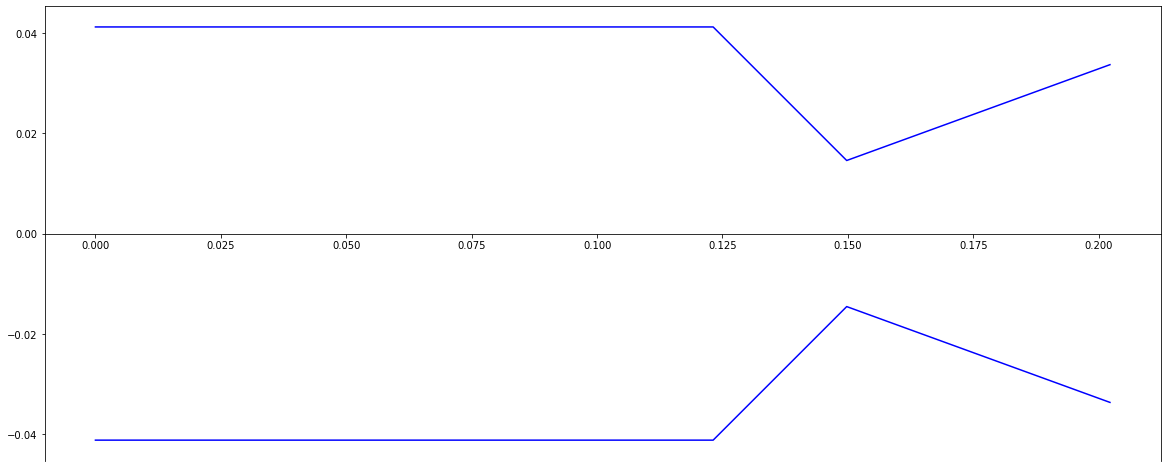

In [37]:
# draw nozzle diagram to give an idea of proportions
%matplotlib inline
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot()
pts=[(0,r_chamber_m), (L_chamber_m,r_chamber_m), (L_chamber_m+L_converging_m,r_throat_m), (L_chamber_m+L_converging_m+L_diverging_m, r_exit_m)]
xs, ys = zip(*pts)
neg_ys = [-y for y in ys]
ax.set_aspect('equal', 'box')
ax.spines.bottom.set_position('zero')
ax.plot(xs,ys,'b',xs,neg_ys,'b')

## Injector

In [38]:
#input parameters
dP_injector_ox_bar = 5 #pressure drop in ox. inj.
Cd_injector_ox = 0.7 #discharge coefficient in ox inj.
n_injectors_ox = 8

dP_injector_fuel_bar = 5

In [39]:
def injector_area(mdot, Cd, rho, delta_P):
    '''returns total area of injector required to achieve a given mass flow rate,
    given Cd for injector, density of fuel, and pressure drop across injector.
    assumes incompressible fluid flow through a hydraulic orifice (perhaps unreasonable for our oxidiser, GOX...)'''
    return mdot / Cd / np.sqrt(2 * rho * delta_P * 1e5)

In [40]:
# fuel injector
# fuel volume flow rate, used to pick a spray nozzle part
V_dot_fuel_m3ps = m_dot_fuel_kgps / rho_fuel_kgpm3
P_fuel_injector_bar = P_chamber_bar + dP_injector_fuel_bar
print(f'Fuel volume flow rate: {V_dot_fuel_m3ps*1e3:.3f}L/s')


Fuel volume flow rate: 0.623L/s


In [41]:
# oxidiser injector
# lookup oxidiser density at injector inlet using CoolProp
ox = thermo.chemical.Chemical(ox_chem)
ox.calculate(T=T_initial_ox_K, P=P_chamber_bar*constants.bar)
rho_ox_chamber_kgpm3 = ox.rho
ox.calculate(T=T_initial_ox_K, P=P_initial_ox_bar*constants.bar)
rho_ox_tank_kgpm3 = ox.rho
ox.calculate(T=T_initial_ox_K, P=P_std_bar*constants.bar)
rho_ox_std_kgpm3 = ox.rho

P_ox_injector_bar = P_chamber_bar + dP_injector_ox_bar

V_dot_injector_ox_m3ps = m_dot_ox_kgps / rho_ox_chamber_kgpm3
V_dot_tank_ox_m3ps = m_dot_ox_kgps/rho_ox_tank_kgpm3
print(f'Oxidiser volume flow rate: {V_dot_injector_ox_m3ps*1e3:.3f}L/s ({V_dot_tank_ox_m3ps*1e3:.3f}L/s exiting tank)')
V_dot_ox_stdft3ps = (m_dot_ox_kgps / rho_ox_std_kgpm3) * 35.315
print(f'Oxidiser flow, std. ft^3/s: {V_dot_ox_stdft3ps:.1f}')

# injector area
A_injector_ox_m2 = injector_area(
    m_dot_ox_kgps,
    Cd_injector_ox,
    rho_ox_chamber_kgpm3,
    dP_injector_ox_bar)
print(f'Total ox. injector area: {A_injector_ox_m2*1e4:.2f}cm^2')
r_injector_ox_m = np.sqrt(A_injector_ox_m2/np.pi/n_injectors_ox)
print(f'Radius of the {n_injectors_ox} ox. injectors: {r_injector_ox_m*1e3:.2f}mm')

Oxidiser volume flow rate: 23.467L/s (3.342L/s exiting tank)
Oxidiser flow, std. ft^3/s: 25.2
Total ox. injector area: 2.11cm^2
Radius of the 8 ox. injectors: 2.90mm


## Propellant tanks

In [42]:
m_fuel_kg = m_dot_fuel_kgps * dt_burn_s
m_ox_kg = m_dot_ox_kgps * dt_burn_s
print(f'{dt_burn_s}s burn consumes {m_fuel_kg:.1f}kg fuel and {m_ox_kg:.1f}kg oxidizer.')

V_fuel_tank_m3 = m_fuel_kg / rho_fuel_kgpm3
print(f'Fuel volume: {V_fuel_tank_m3*1e3:.1f}L')

V_ox_tank_m3 = m_ox_kg / rho_ox_tank_kgpm3
print(f'(approx.) Oxidiser tank volume: {V_ox_tank_m3*1e3:.1f}L')

print(f'Oxidiser tank SCF (std. ft^3): {V_dot_ox_stdft3ps*dt_burn_s:.1f}')

30s burn consumes 15.1kg fuel and 28.0kg oxidizer.
Fuel volume: 18.7L
(approx.) Oxidiser tank volume: 100.3L
Oxidiser tank SCF (std. ft^3): 754.9


## Valves

In [59]:
# Main fuel valve
P1 = P_fuel_tank_bar*constants.bar  # before valve
P2 = P_fuel_injector_bar*constants.bar  # after valve
# approx. fuel with gasoline (octane) for now
# approx. pressure in valve as midway between pressure before and after valve
fuel = thermo.chemical.Chemical('C8H18', T=T_initial_fuel_K, P=(P1+P2)/2)
Cv_main_fuel = fluids.Kv_to_Cv(fluids.size_control_valve_l(rho=rho_fuel_kgpm3,
                                                           Psat=fuel.Psat,
                                                           Pc=fuel.Pc,
                                                           mu=fuel.mu,
                                                           P1=P1,
                                                           P2=P2,
                                                           Q=V_dot_fuel_m3ps))
print(f'Min. Cv for main fuel valve: {Cv_main_fuel:.1f}')

# Main oxidiser valve
P1 = P_initial_ox_bar*constants.bar
P2 = P_ox_injector_bar*constants.bar
ox.calculate(T=T_initial_ox_K, P=(P1+P2)/2)
Cv_main_ox = fluids.Kv_to_Cv(fluids.size_control_valve_g(T=T_initial_ox_K,
                                                         MW=ox.MW,
                                                         mu=0, # thermo lib won't give a viscosity for ideal gas?
                                                         gamma=ox.isentropic_exponent,
                                                         Z=ox.Z,
                                                         P1=P1,
                                                         P2=P2,
                                                         Q=V_dot_ox_stdft3ps * (constants.foot**3)))

print(f'for main ox valve: {Cv_main_ox:.2f}')




Min. Cv for main fuel valve: 1.0
for main ox valve: 1.02
